# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
##### %matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# Note

* loading the preprocessed data from final.sqlite which is done in previous assignments

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sqlite3.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
final = pd.read_sql_query("""
SELECT * FROM Reviews""",con)

#Reviews is the name of the table given
final=final[:50000]

In [3]:
final.shape

(50000, 12)

In [4]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [5]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (35000, 2353)
the number of unique words : 2353


In [6]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [7]:
# Please write all the code with proper documentation
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized) 

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9218919871187186
The optimal value of C(1/lambda) is :  0.01


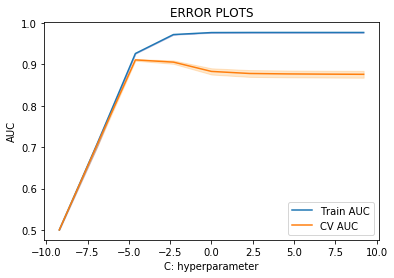

In [8]:
C = [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

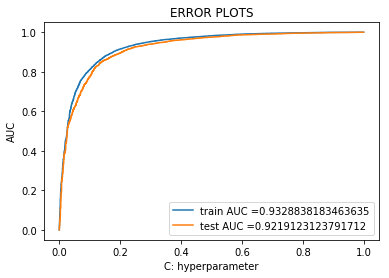

In [9]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [10]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 90.060000%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.907019

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.983832

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.943865


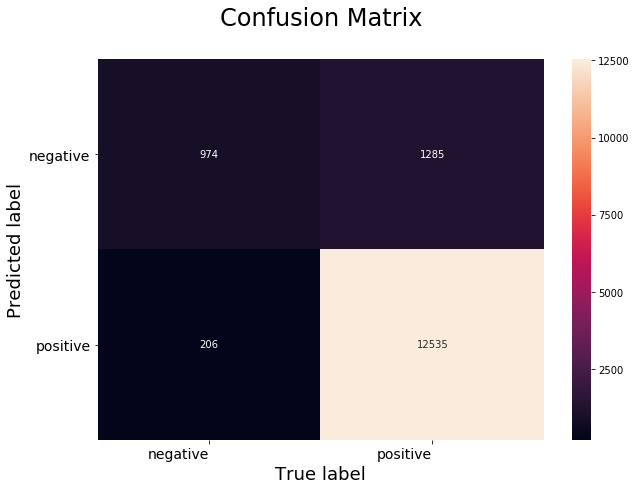

In [11]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [12]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.010 is 90.691429%

The Train Precision of the Logistic Regression classifier for C = 0.010 is 0.912038

The Train Recall of the Logistic Regression classifier for C = 0.010 is 0.985738

The Train F1-Score of the Logistic regression classifier for C = 0.010 is 0.947457


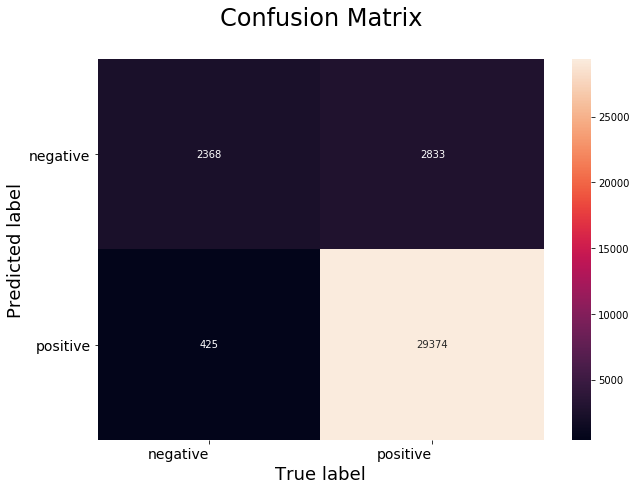

In [13]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# perbutation test

In [14]:
import scipy as sp
from scipy.sparse import csr_matrix

epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.00076481, 0.00076244, 0.00073058, 0.00056748, 0.00045627,
       0.00038059, 0.00037968, 0.00033418, 0.00029357, 0.00028861,
       0.00028218, 0.00025892, 0.0002399 , 0.00022067, 0.00021692,
       0.00021195, 0.00019518, 0.00019353, 0.0001919 , 0.00019122])

* OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [15]:
# Please write all the code with proper documentation
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

2315


In [16]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

1968


In [17]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

567


In [18]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

20


* note:as we increase lambda(1/c) non-zero values of w gets decreased

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [19]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9208696960060238
The optimal value of C(1/lambda) is :  0.001


In [20]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l2_grid_C = optimal_C
bow_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

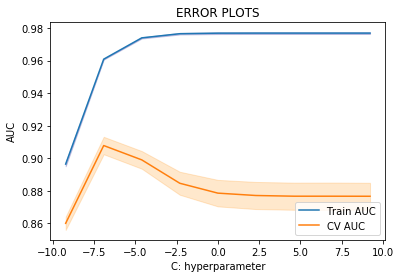

In [21]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

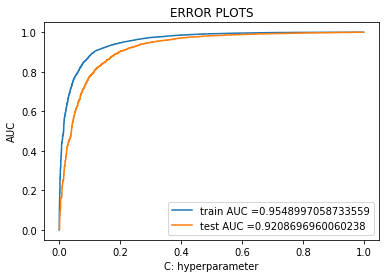

In [22]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [23]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.001 is 91.226667%

The Test Precision of the Logistic Regression classifier for C = 0.001 is 0.924185

The Test Recall of the Logistic Regression classifier for C = 0.001 is 0.976846

The Test F1-Score of the Logistic regression classifier for C = 0.001 is 0.949786


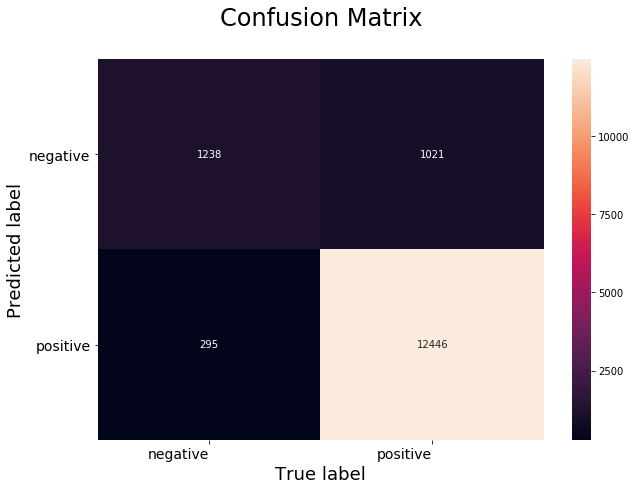

In [24]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [25]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.001 is 92.862857%

The Train Precision of the Logistic Regression classifier for C = 0.001 is 0.935020

The Train Recall of the Logistic Regression classifier for C = 0.001 is 0.984597

The Train F1-Score of the Logistic regression classifier for C = 0.001 is 0.959168


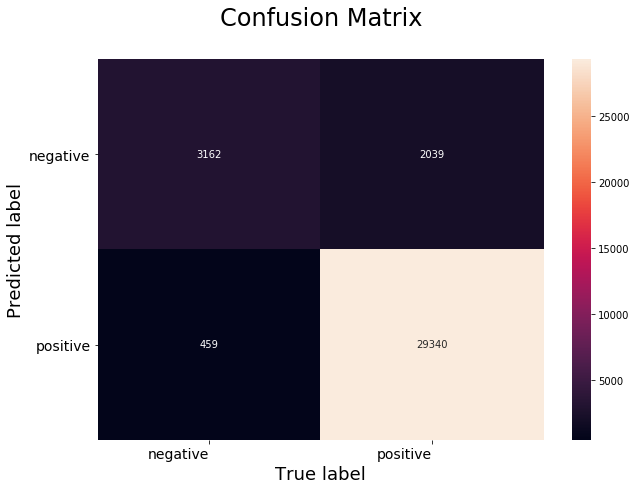

In [26]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon

# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([4.81188899e-06, 4.09087562e-06, 2.78226114e-06, 2.48401926e-06,
       2.04200991e-06, 1.85612329e-06, 1.84738474e-06, 1.81345439e-06,
       1.52356282e-06, 1.48295984e-06, 1.46663642e-06, 1.43867835e-06,
       1.43332615e-06, 1.39369381e-06, 1.39099927e-06, 1.37055991e-06,
       1.36252223e-06, 1.34944209e-06, 1.34669351e-06, 1.33079896e-06])

* OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [28]:
# Please write all the code with proper documentation
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are
c=1
print("Top 10 features with their weight values :")
for j in top_index:
    if weight_values[0,j]>=0:
        if c<=10:
            c=c+1
            print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))
        else:
            break

Top 10 features with their weight values :
       great	--> 	0.392660
        love	--> 	0.353352
        best	--> 	0.286805
        good	--> 	0.236168
      delici	--> 	0.234165
       excel	--> 	0.200661
     perfect	--> 	0.191553
        nice	--> 	0.153518


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [30]:
# Please write all the code with proper documentation
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are
c=1
print("Top 10 features with their weight values :")
for j in top_index:
    if weight_values[0,j]<0:
        if c<=10:
            c=c+1
            print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))
        else:
            break

Top 10 features with their weight values :
  disappoint	--> 	-0.225403
       worst	--> 	-0.167996


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [31]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (35000, 2353)
the number of unique words : 2353


### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [33]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9303291417087236
The optimal value of C(1/lambda) is :  0.01


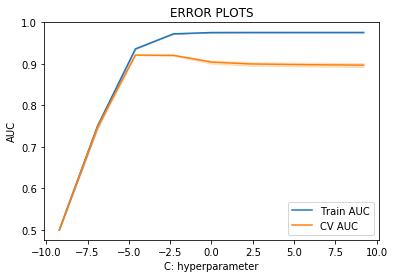

In [34]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

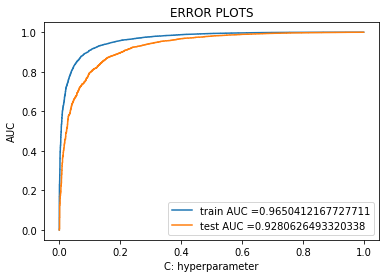

In [35]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [36]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010000 is 91.060000%

The Test Precision of the Logistic Regression classifier for C = 0.010000 is 0.934849

The Test Recall of the Logistic Regression classifier for C = 0.010000 is 0.961777

The Test F1-Score of the Logistic regression classifier for C = 0.010000 is 0.948122


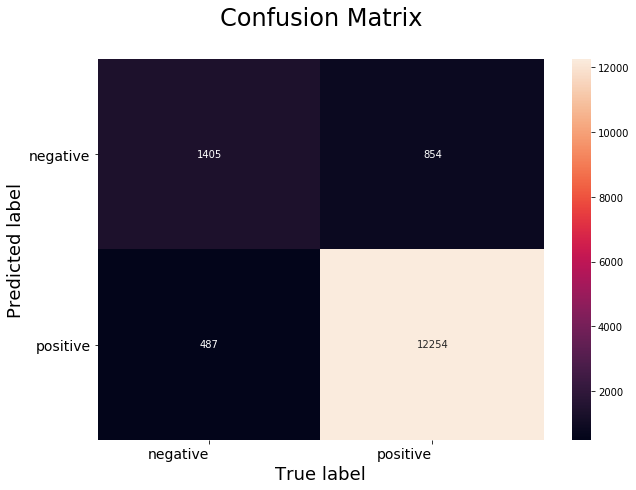

In [37]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [38]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.010000 is 93.597143%

The Train Precision of the Logistic Regression classifier for C = 0.010000 is 0.949266

The Train Recall of the Logistic Regression classifier for C = 0.010000 is 0.977013

The Train F1-Score of the Logistic regression classifier for C = 0.010000 is 0.962940


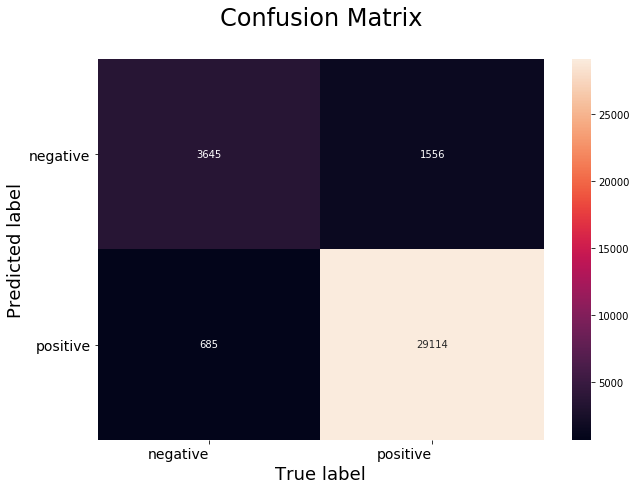

In [39]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [40]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l2_grid_C = optimal_C
tfidf_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9329204213242348
The optimal value of C(1/lambda) is :  0.001


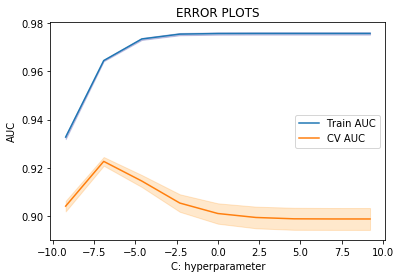

In [41]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

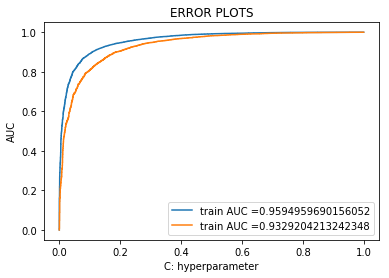

In [42]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [43]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.001 is 91.153333%

The Test Precision of the Logistic Regression classifier for C = 0.001 is 0.926086

The Test Recall of the Logistic Regression classifier for C = 0.001 is 0.973550

The Test F1-Score of the Logistic regression classifier for C = 0.001 is 0.949225


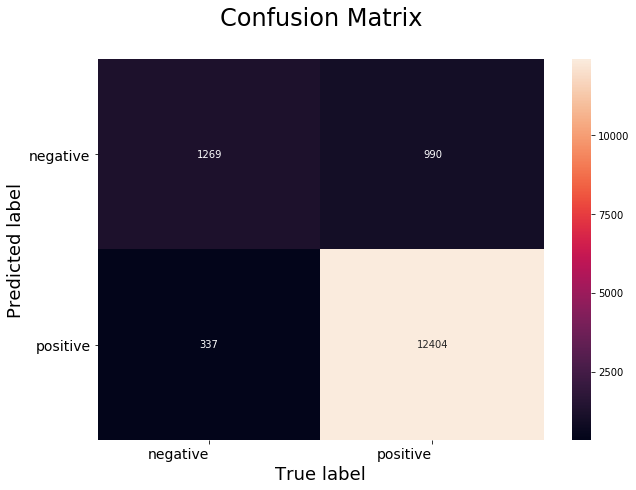

In [44]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [45]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.001000 is 92.865714%

The Train Precision of the Logistic Regression classifier for C = 0.001000 is 0.936469

The Train Recall of the Logistic Regression classifier for C = 0.001000 is 0.982885

The Train F1-Score of the Logistic regression classifier for C = 0.001000 is 0.959116


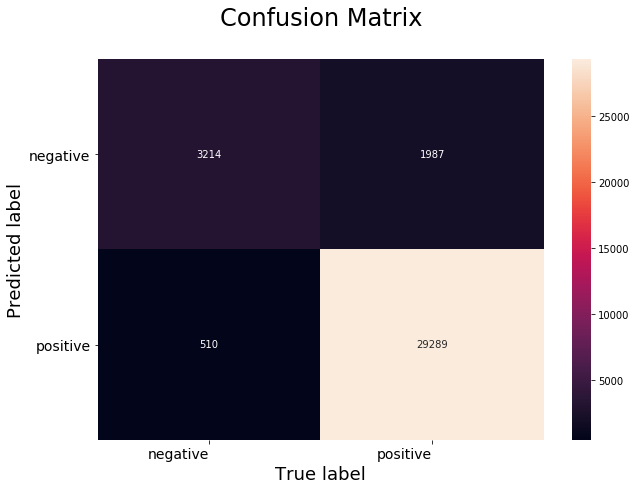

In [46]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# perbutation test

In [47]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([4.51455930e-07, 3.88755280e-07, 3.61103125e-07, 3.57918429e-07,
       3.41190040e-07, 3.00852743e-07, 2.98315306e-07, 2.54441354e-07,
       2.53475495e-07, 2.53373200e-07, 2.17614058e-07, 2.07224612e-07,
       2.03358695e-07, 2.02235739e-07, 2.02100082e-07, 2.01158879e-07,
       2.00151944e-07, 1.96066536e-07, 1.92765910e-07, 1.92317682e-07])

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [48]:
# Please write all the code with proper documentation
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("Top 10 features with their weight values :")

for j in top_index:
    if weight_values[0,j]>=0:
        print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 features with their weight values :
       great	--> 	0.362961
        love	--> 	0.346122
        best	--> 	0.276506
        good	--> 	0.237309
      delici	--> 	0.212318
       excel	--> 	0.182622
     perfect	--> 	0.178855
        find	--> 	0.162457


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [49]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:10]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 10 features are    
print("Top 10 features with their weight values :")

for j in top_index:
    if weight_values[0,j]<0:
        print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 10 features with their weight values :
  disappoint	--> 	-0.202310
       worst	--> 	-0.157972


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [50]:
#W2V
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  8315


In [51]:
#AVG-W2V
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)    

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [62]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8880782063211282
The optimal value of C(1/lambda) is :  1


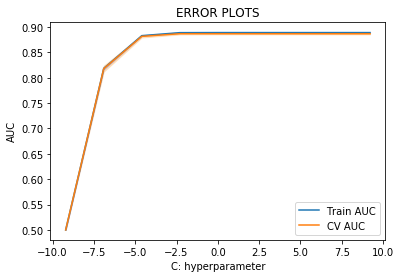

In [63]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

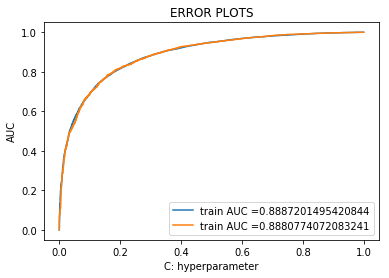

In [64]:
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Accurract on test data

In [65]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 88.246667%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.898678

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.971117

The Test F1-Score of the Logistic regression classifier for C = 1.000 is 0.933494


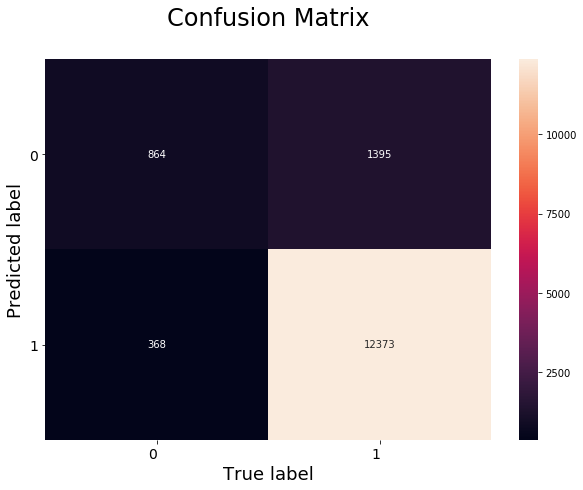

In [66]:
# Code for drawing seaborn heatmaps
class_names = [0,1]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [67]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 1.000000 is 88.397143%

The Train Precision of the Logistic Regression classifier for C = 1.000000 is 0.902257

The Train Recall of the Logistic Regression classifier for C = 1.000000 is 0.968657

The Train F1-Score of the Logistic regression classifier for C = 1.000000 is 0.934278


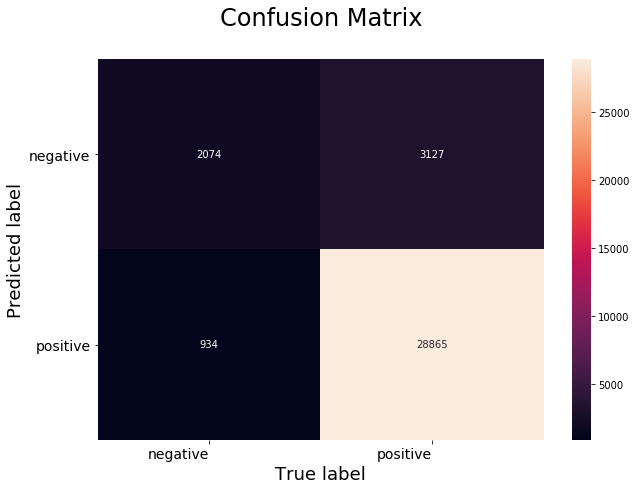

In [68]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [69]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l2_grid_C = optimal_C
avg_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8880615291843468
The optimal value of C(1/lambda) is :  0.1


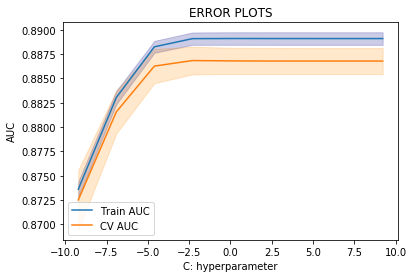

In [70]:
C = [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

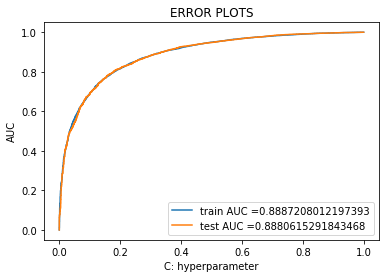

In [71]:
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Accuracy on test data

In [72]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 88.260000%

The Test Precision of the Logistic Regression classifier for C = 0.100 is 0.898346

The Test Recall of the Logistic Regression classifier for C = 0.100 is 0.971745

The Test F1-Score of the Logistic regression classifier for C = 0.100 is 0.933605


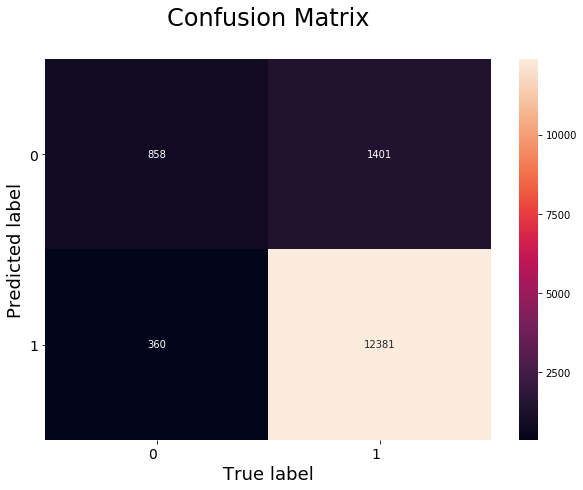

In [73]:
# Code for drawing seaborn heatmaps
class_names = [0,1]
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [74]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.100000 is 88.411429%

The Train Precision of the Logistic Regression classifier for C = 0.100000 is 0.902146

The Train Recall of the Logistic Regression classifier for C = 0.100000 is 0.968992

The Train F1-Score of the Logistic regression classifier for C = 0.100000 is 0.934375


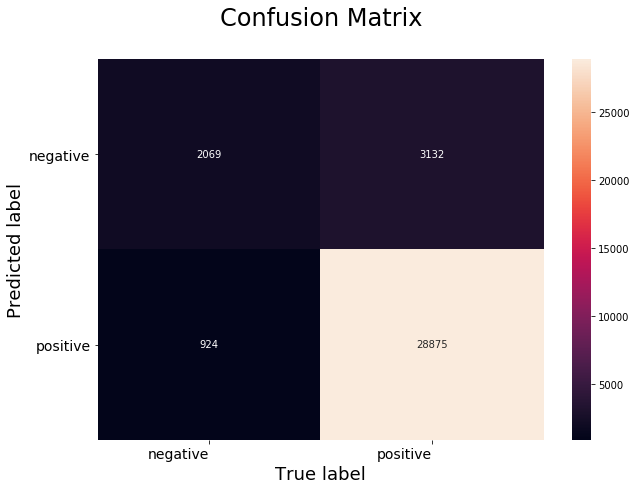

In [75]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [76]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [77]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)    

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [78]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0,10**1, 10**2,10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l1_grid_C = optimal_C
tfidf_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.605620181197786
The optimal value of C(1/lambda) is :  0.1


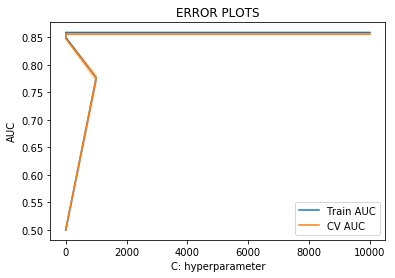

In [79]:
C = [10**-4, 10**3,10**-2, 10**1,10**0,10**1,10**2 ,10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

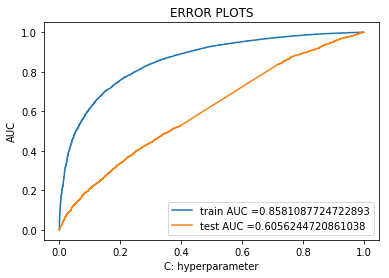

In [80]:
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Accuracy on test data

In [81]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 75.300000%

The Test Precision of the Logistic Regression classifier for C = 0.100 is 0.867796

The Test Recall of the Logistic Regression classifier for C = 0.100 is 0.836669

The Test F1-Score of the Logistic regression classifier for C = 0.100 is 0.851948


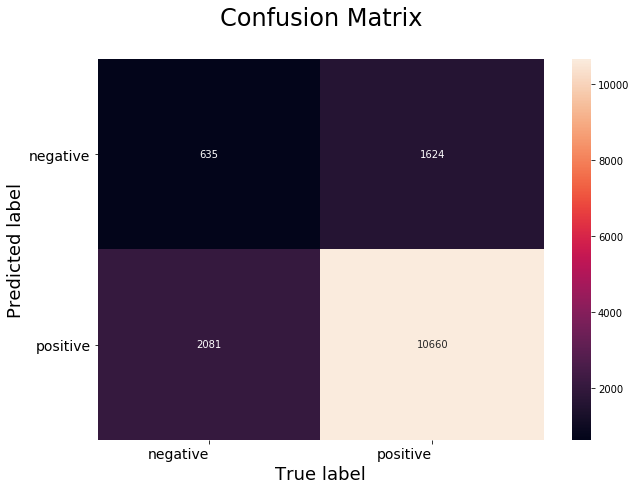

In [82]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [83]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.100000 is 87.108571%

The Train Precision of the Logistic Regression classifier for C = 0.100000 is 0.887113

The Train Recall of the Logistic Regression classifier for C = 0.100000 is 0.972315

The Train F1-Score of the Logistic regression classifier for C = 0.100000 is 0.927762


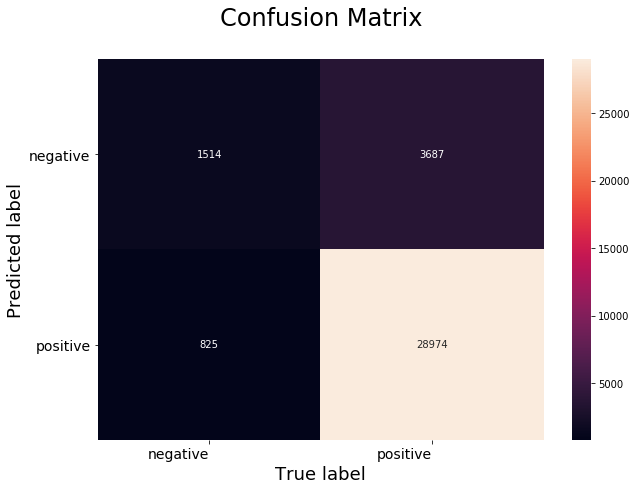

In [84]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [85]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1, 10**0, 10**1,10**2,10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l2_grid_C = optimal_C
tfidf_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.605399938760164
The optimal value of C(1/lambda) is :  0.1


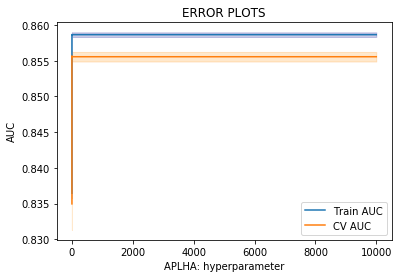

In [86]:
C = [10**-4,10**-3,10**-2, 10**-1, 10**0,10**1, 10**2,10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(C, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("APLHA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

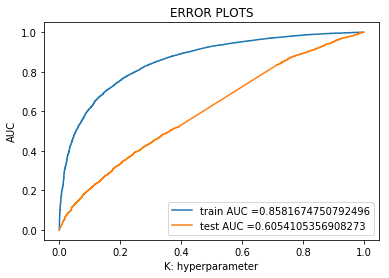

In [87]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# accuracy on test data

In [88]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.100 is 75.260000%

The Test Precision of the Logistic Regression classifier for C = 0.100 is 0.868031

The Test Recall of the Logistic Regression classifier for C = 0.100 is 0.835806

The Test F1-Score of the Logistic regression classifier for C = 0.100 is 0.851613


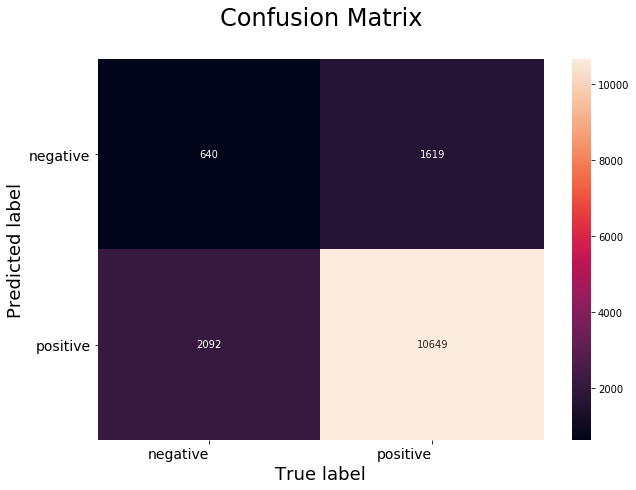

In [89]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [90]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall-
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.100000 is 87.140000%

The Train Precision of the Logistic Regression classifier for C = 0.100000 is 0.887792

The Train Recall of the Logistic Regression classifier for C = 0.100000 is 0.971778

The Train F1-Score of the Logistic regression classifier for C = 0.100000 is 0.927888


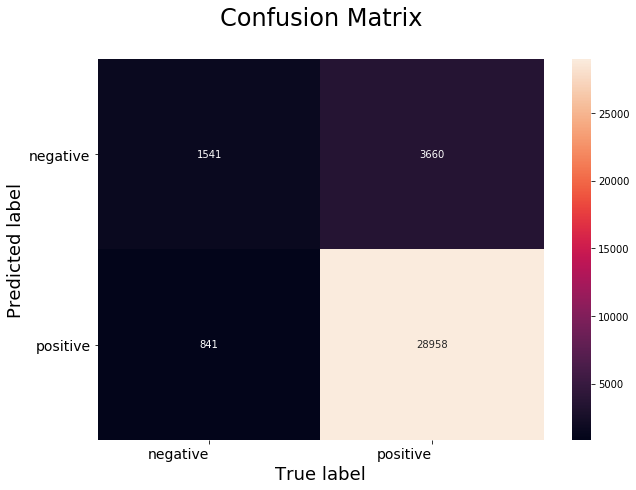

In [91]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# procedure

* STEP 1 :- Text Preprocessing(where i combined cleaned text,summary twice)
* STEP 2:- Time-based splitting of whole dataset into train_data and test_data
* STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors
* STEP 4:- Using Logistic regression as an estimator in  GridSearchCV in order to find optimal value of C i.e(1/lambda) with both L1 and L2 regularisation
* STEP 5:- Draw various plots auc's vs c
* STEP 6:- Once , we get optimal value of C then train Logistic Regression (both L1 and L2 regularisation) again with this optimal C and make predictions on test_data
* STEP 7:- Find important features per class either +ve or -ve
* STEP 8 :- Evaluate : Accuracy , F1-Score , Precision , Recall , TPR , FPR , TNR , FNR
* STEP 9:- Draw Seaborn Heatmap for Confusion Matrix .
* STEP 10:- Perform multicollinearity check and find important features (Only for BoW and TFIDF vectorizers)
* STEP 11:- Creating more sparsity by increasing value of lambda i.e.(1/C) (Only for L1 regularisation)

# [6] Conclusions

In [92]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['LR(l1|GridSearchCV) for BoW','LR(l2|GridSearchCV) for BoW',\
         'LR(l1|GridSearchCV) for TFIDF','LR(l2|GridSearchCV) for TFIDF',\
         'LR(l1|GridSearchCV) for Avg_Word2Vec','LR(l2|GridSearchCV) for Avg_Word2Vec',\
         'LR(l1|GridSearchCV) for tfidf_Word2Vec','LR(l2|GridSearchCV) for tfidf_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_C = [bow_l1_grid_C,bow_l2_grid_C,\
             tfidf_l1_grid_C,tfidf_l2_grid_C,\
             avg_w2v_l1_grid_C,avg_w2v_l2_grid_C,\
             tfidf_w2v_l1_grid_C,tfidf_w2v_l2_grid_C]

# Training accuracies
train_acc = [bow_l1_grid_train_acc,bow_l2_grid_train_acc,\
             tfidf_l1_grid_train_acc,tfidf_l2_grid_train_acc,\
             avg_w2v_l1_grid_train_acc,avg_w2v_l2_grid_train_acc,\
             tfidf_w2v_l1_grid_train_acc,tfidf_w2v_l2_grid_train_acc]

# Test accuracies
test_acc = [bow_l1_grid_test_acc,bow_l2_grid_test_acc,\
             tfidf_l1_grid_test_acc,tfidf_l2_grid_test_acc,\
             avg_w2v_l1_grid_test_acc,avg_w2v_l2_grid_test_acc,\
             tfidf_w2v_l1_grid_test_acc,tfidf_w2v_l2_grid_test_acc]

sno = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)


#LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV
#LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV
# Printing the Table
print(ptable)

+-------+----------------------------------------+------------------+--------------------+-------------------+
| S.NO. |                 MODEL                  | Best C(1/lambda) | Training Accuracy  |   Test Accuracy   |
+-------+----------------------------------------+------------------+--------------------+-------------------+
|   1   |      LR(l1|GridSearchCV) for BoW       |       0.01       | 92.18919871187185  |       90.06       |
|   2   |      LR(l2|GridSearchCV) for BoW       |      0.001       | 92.08696960060237  | 91.22666666666667 |
|   3   |     LR(l1|GridSearchCV) for TFIDF      |       0.01       | 93.03291417087236  |       91.06       |
|   4   |     LR(l2|GridSearchCV) for TFIDF      |      0.001       | 93.29204213242348  | 91.15333333333334 |
|   5   |  LR(l1|GridSearchCV) for Avg_Word2Vec  |        1         | 88.80782063211282  | 88.24666666666666 |
|   6   |  LR(l2|GridSearchCV) for Avg_Word2Vec  |       0.1        | 88.80615291843468  |       88.26       |
|

# feature engineering

In [93]:
conn = sqlite3.connect('featureeng.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn) 
final.head()

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love book miss hard cover version
2,2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup rice month
3,3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...,good swingi rhythm read aloud
4,4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn month


In [94]:
final=final[:50000]
final.shape

(50000, 14)

In [95]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# bow

In [96]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (35000, 2402)
the number of unique words : 2402


In [97]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

# logistic reg l1

In [98]:
# Please write all the code with proper documentation
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized) 

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9433276321846364
The optimal value of C(1/lambda) is :  0.01


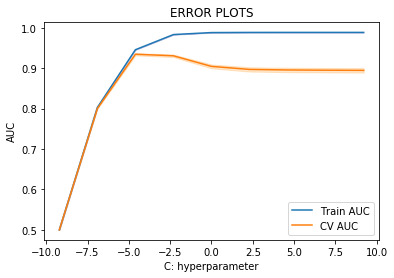

In [99]:
C = [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

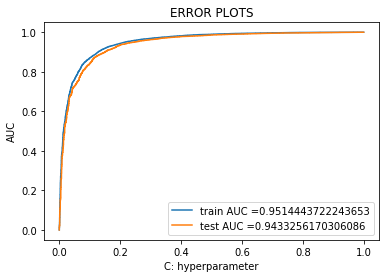

In [100]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# on test data

In [101]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 91.460000%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.921447

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.983282

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.951361


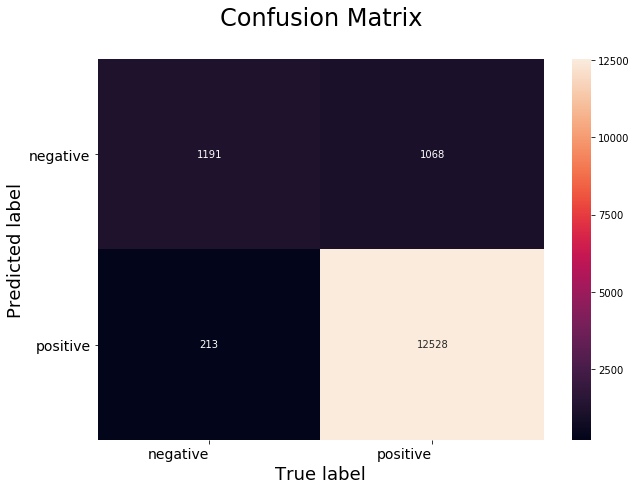

In [102]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# accuracy on train data

In [103]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.010 is 92.277143%

The Train Precision of the Logistic Regression classifier for C = 0.010 is 0.927355

The Train Recall of the Logistic Regression classifier for C = 0.010 is 0.986577

The Train F1-Score of the Logistic regression classifier for C = 0.010 is 0.956049


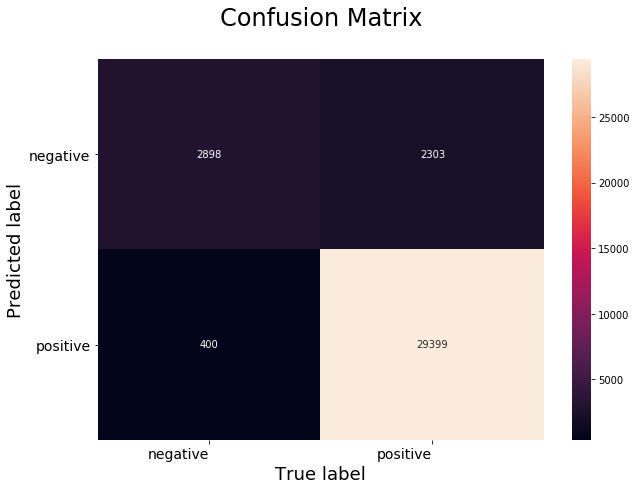

In [104]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# l2 reg 

In [105]:
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized) 

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9431561182560482
The optimal value of C(1/lambda) is :  0.001


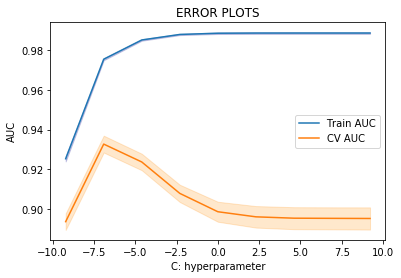

In [106]:
C = [10**-4, 10**-3, 10**-2,10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

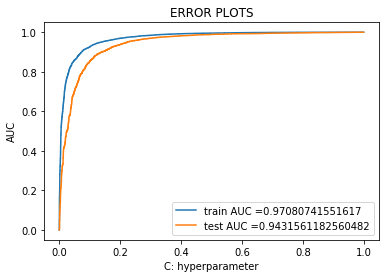

In [107]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# accuracy on test data

In [108]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.001 is 92.580000%

The Test Precision of the Logistic Regression classifier for C = 0.001 is 0.935767

The Test Recall of the Logistic Regression classifier for C = 0.001 is 0.979907

The Test F1-Score of the Logistic regression classifier for C = 0.001 is 0.957329


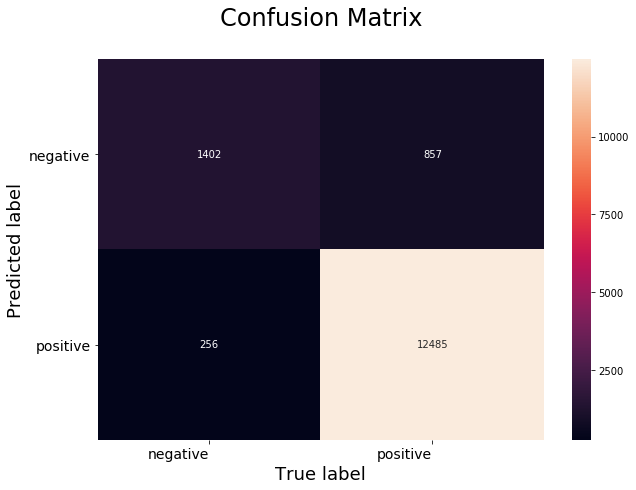

In [109]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on train data

In [110]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.001 is 94.148571%

The Train Precision of the Logistic Regression classifier for C = 0.001 is 0.946718

The Train Recall of the Logistic Regression classifier for C = 0.001 is 0.986812

The Train F1-Score of the Logistic regression classifier for C = 0.001 is 0.966349


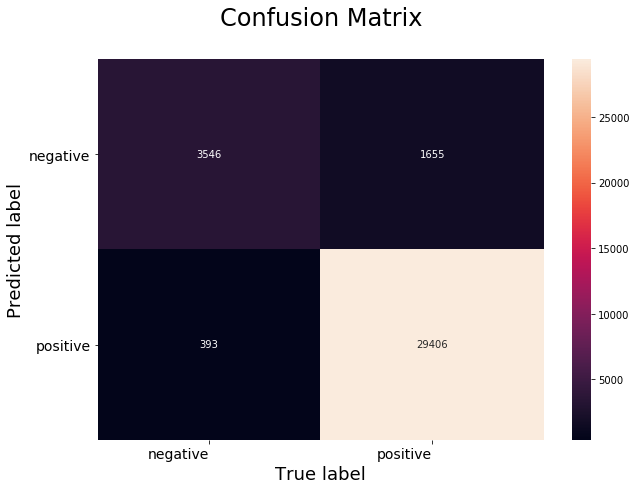

In [111]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# tfidf l1 reg logistic regression

In [112]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (35000, 2402)
the number of unique words : 2402


In [120]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9488353260948306
The optimal value of C(1/lambda) is :  0.01


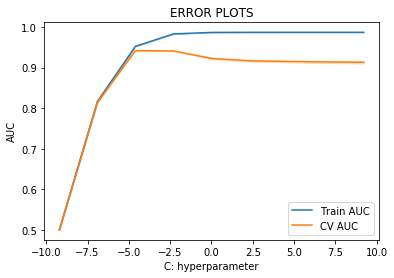

In [121]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

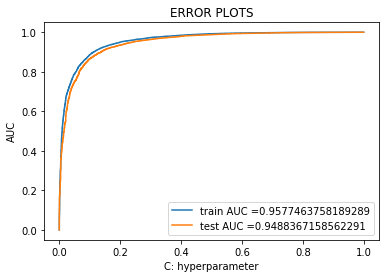

In [122]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# on test data

In [123]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 92.053333%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.927456

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.983361

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.954590


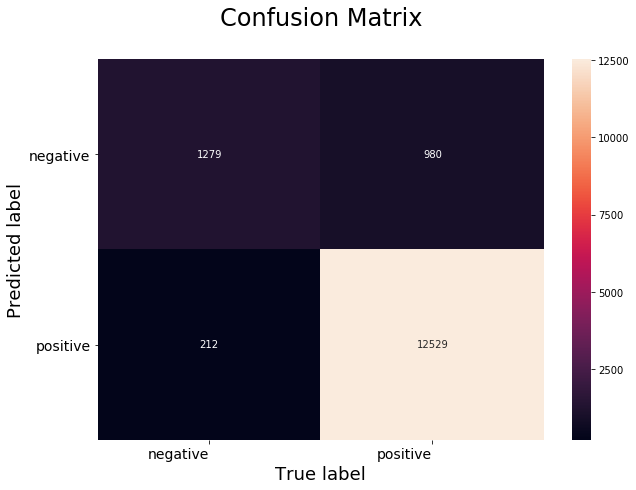

In [124]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on train data

In [125]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.010 is 92.674286%

The Train Precision of the Logistic Regression classifier for C = 0.010 is 0.932014

The Train Recall of the Logistic Regression classifier for C = 0.010 is 0.985872

The Train F1-Score of the Logistic regression classifier for C = 0.010 is 0.958187


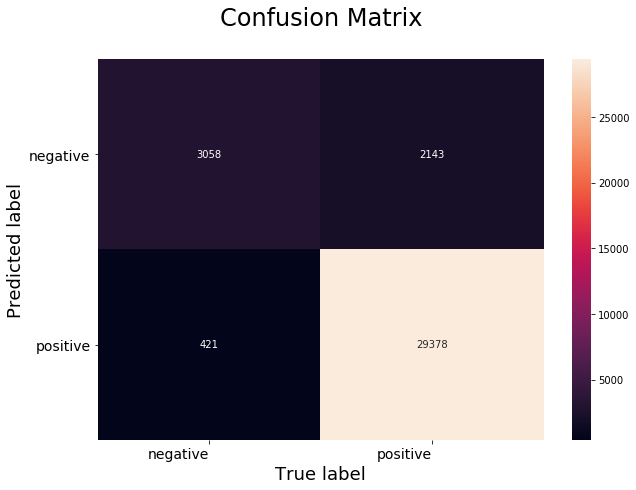

In [126]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on l2 reg

In [127]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9512236484301134
The optimal value of C(1/lambda) is :  0.001


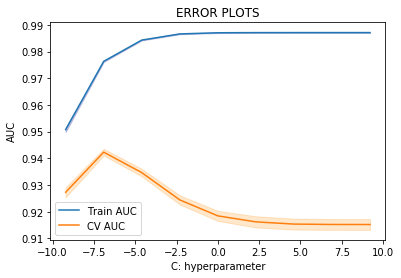

In [128]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

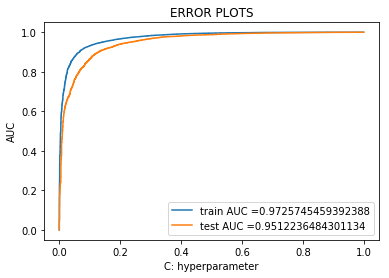

In [129]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# on test data

In [130]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.001 is 92.560000%

The Test Precision of the Logistic Regression classifier for C = 0.001 is 0.935948

The Test Recall of the Logistic Regression classifier for C = 0.001 is 0.979436

The Test F1-Score of the Logistic regression classifier for C = 0.001 is 0.957199


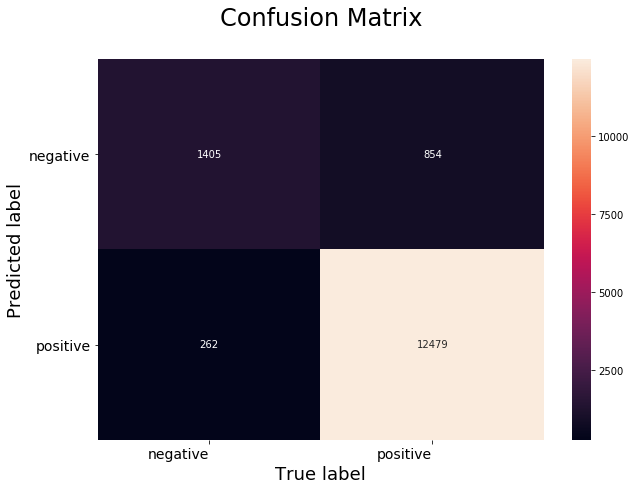

In [131]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on train data

In [132]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 0.001 is 93.942857%

The Train Precision of the Logistic Regression classifier for C = 0.001 is 0.945903

The Train Recall of the Logistic Regression classifier for C = 0.001 is 0.985201

The Train F1-Score of the Logistic regression classifier for C = 0.001 is 0.965152


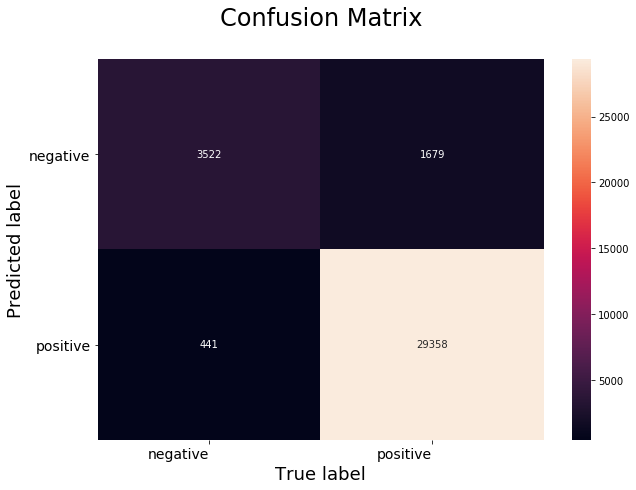

In [133]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# avgw2v l1 reg using logistic regression

In [134]:
#W2V
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  11176


In [135]:
#AVG-W2V
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)    

In [136]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9246390416149806
The optimal value of C(1/lambda) is :  10


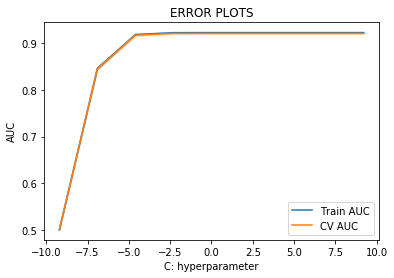

In [137]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

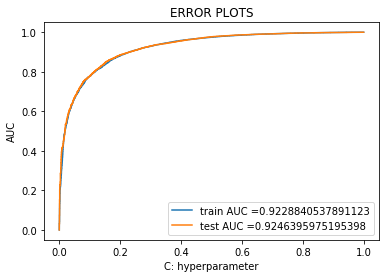

In [138]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# accuracy on test data

In [139]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 10.000 is 90.526667%

The Test Precision of the Logistic Regression classifier for C = 10.000 is 0.920318

The Test Recall of the Logistic Regression classifier for C = 10.000 is 0.972687

The Test F1-Score of the Logistic regression classifier for C = 10.000 is 0.945778


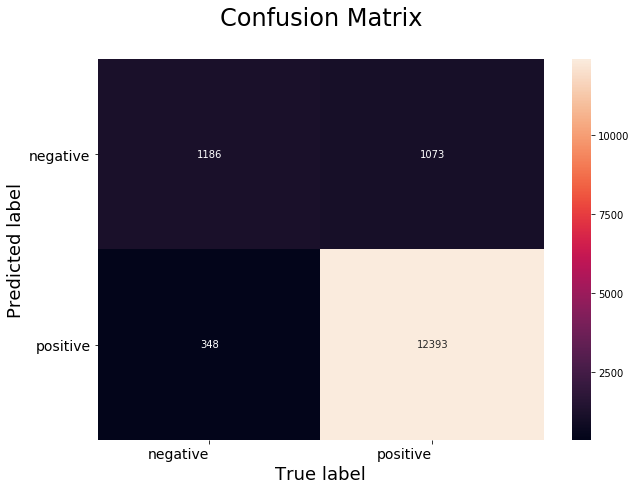

In [140]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on train data

In [141]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 10.000 is 90.488571%

The Train Precision of the Logistic Regression classifier for C = 10.000 is 0.922925

The Train Recall of the Logistic Regression classifier for C = 10.000 is 0.969227

The Train F1-Score of the Logistic regression classifier for C = 10.000 is 0.945509


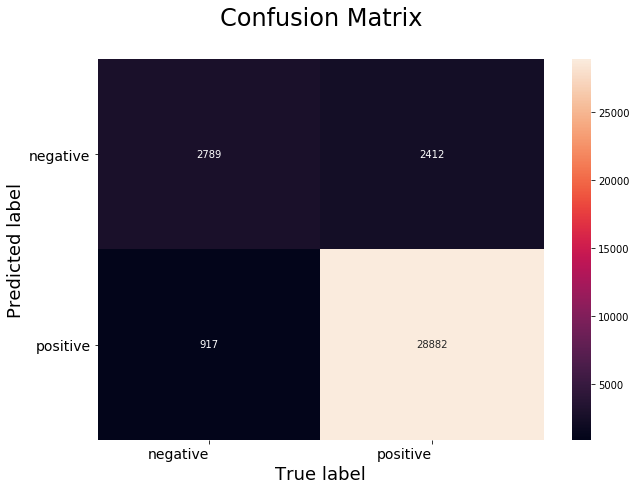

In [142]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# using l2 reg

In [143]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9246377560856871
The optimal value of C(1/lambda) is :  1


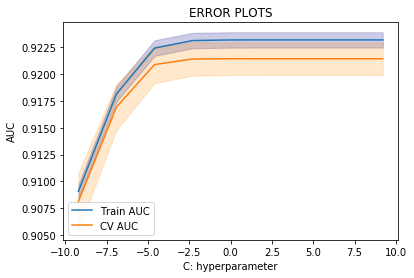

In [144]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

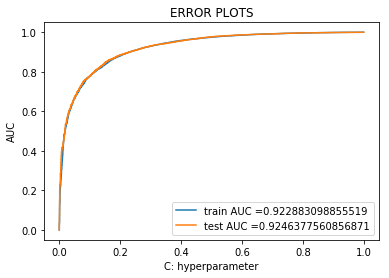

In [145]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [146]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 90.553333%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.920466

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.972844

The Test F1-Score of the Logistic regression classifier for C = 1.000 is 0.945930


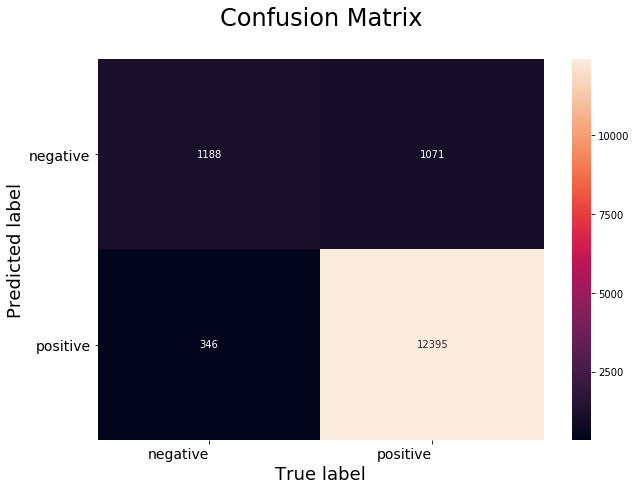

In [147]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# on train data

In [148]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 1.000 is 90.494286%

The Train Precision of the Logistic Regression classifier for C = 1.000 is 0.922929

The Train Recall of the Logistic Regression classifier for C = 1.000 is 0.969294

The Train F1-Score of the Logistic regression classifier for C = 1.000 is 0.945544


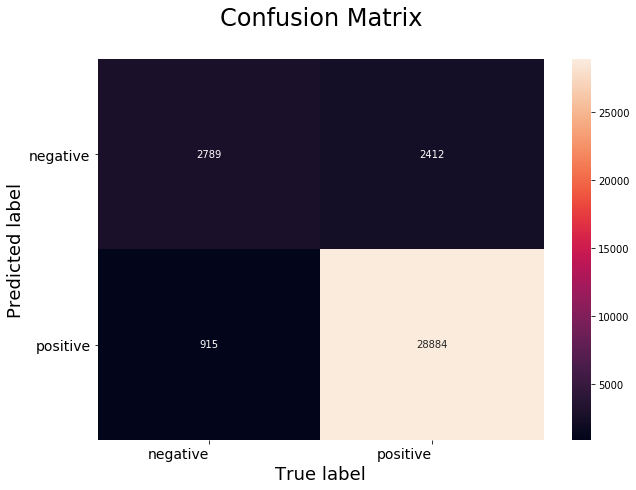

In [149]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# tfidf w2v on logistic regression using l1 reg

In [150]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [151]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)    

In [152]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.6204737078163551
The optimal value of C(1/lambda) is :  1


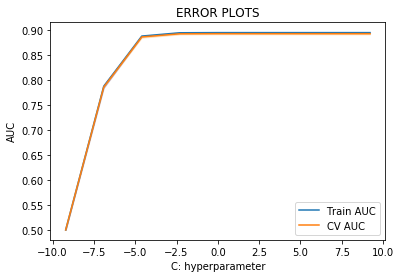

In [153]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

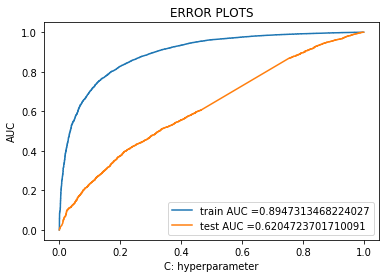

In [154]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# accuracy on test data

In [155]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 58.560000%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.882339

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.590927

The Test F1-Score of the Logistic regression classifier for C = 1.000 is 0.707812


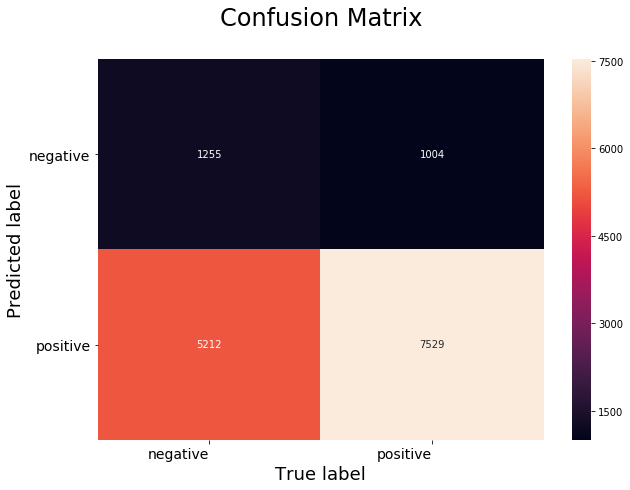

In [156]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# accuracy on train data

In [157]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 1.000 is 89.100000%

The Train Precision of the Logistic Regression classifier for C = 1.000 is 0.907835

The Train Recall of the Logistic Regression classifier for C = 1.000 is 0.970502

The Train F1-Score of the Logistic regression classifier for C = 1.000 is 0.938123


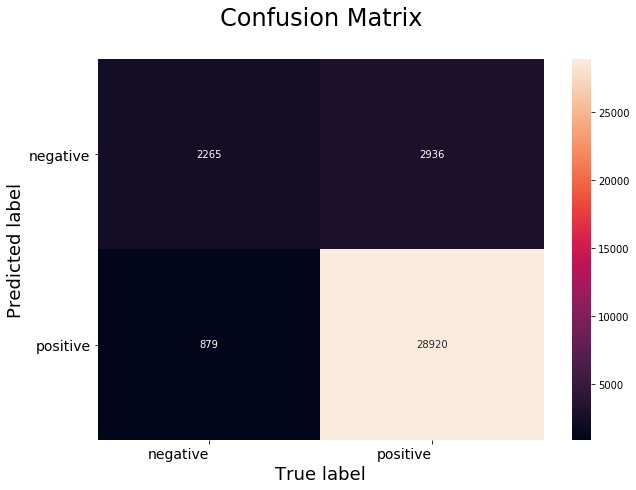

In [158]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# using l2 reg

In [159]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3 ,10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.620071232915359
The optimal value of C(1/lambda) is :  1


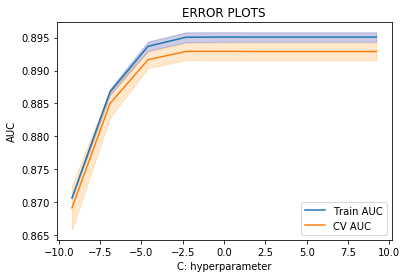

In [160]:
C = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1 ,10**2, 10**3, 10**4]
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score'] 
cv_auc_std= model.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

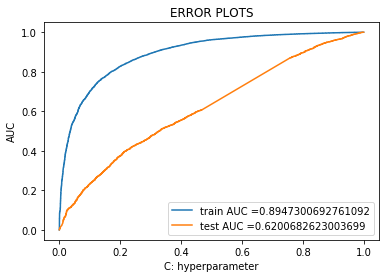

In [161]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train_vec_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, lr.predict_proba(X_test_vec_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


# Accuracy on test data

In [162]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 1) 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 1)
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 1)
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 1.000 is 58.540000%

The Test Precision of the Logistic Regression classifier for C = 1.000 is 0.882298

The Test Recall of the Logistic Regression classifier for C = 1.000 is 0.590691

The Test F1-Score of the Logistic regression classifier for C = 1.000 is 0.707630


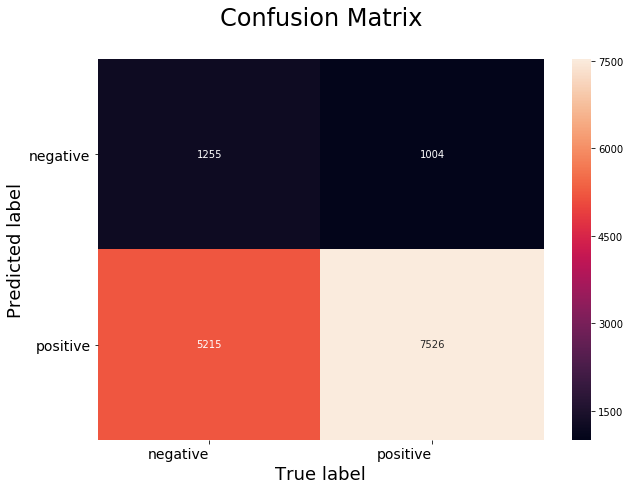

In [163]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Accuracy on train data

In [164]:
# evaluate accuracy
acc = accuracy_score(Y_train, lr.predict(X_train_vec_standardized)) * 100
print('\nThe Train Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1) 
print('\nThe Train Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_train, lr.predict(X_train_vec_standardized), pos_label = 1)
print('\nThe Train F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Train Accuracy of the Logistic Regression classifier for C = 1.000 is 89.088571%

The Train Precision of the Logistic Regression classifier for C = 1.000 is 0.907772

The Train Recall of the Logistic Regression classifier for C = 1.000 is 0.970435

The Train F1-Score of the Logistic regression classifier for C = 1.000 is 0.938059


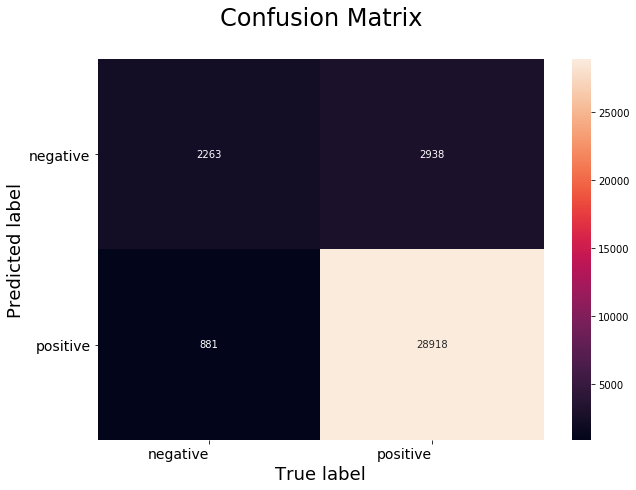

In [165]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_train, lr.predict(X_train_vec_standardized)), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# conclusion

In [166]:
# after using feature engineering

# Names of models
names = ['LR(l1|GridSearchCV) for BoW','LR(l2|GridSearchCV) for BoW',\
         'LR(l1|GridSearchCV) for TFIDF','LR(l2|GridSearchCV) for TFIDF',\
         'LR(l1|GridSearchCV) for Avg_Word2Vec','LR(l2|GridSearchCV) for Avg_Word2Vec',\
         'LR(l1|GridSearchCV) for tfidf_Word2Vec','LR(l2|GridSearchCV) for tfidf_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_C = [bow_l1_grid_C,bow_l2_grid_C,\
             tfidf_l1_grid_C,tfidf_l2_grid_C,\
             avg_w2v_l1_grid_C,avg_w2v_l2_grid_C,\
             tfidf_w2v_l1_grid_C,tfidf_w2v_l2_grid_C]

# Training accuracies
train_acc = [bow_l1_grid_train_acc,bow_l2_grid_train_acc,\
             tfidf_l1_grid_train_acc,tfidf_l2_grid_train_acc,\
             avg_w2v_l1_grid_train_acc,avg_w2v_l2_grid_train_acc,\
             tfidf_w2v_l1_grid_train_acc,tfidf_w2v_l2_grid_train_acc]

# Test accuracies
test_acc = [bow_l1_grid_test_acc,bow_l2_grid_test_acc,\
             tfidf_l1_grid_test_acc,tfidf_l2_grid_test_acc,\
             avg_w2v_l1_grid_test_acc,avg_w2v_l2_grid_test_acc,\
             tfidf_w2v_l1_grid_test_acc,tfidf_w2v_l2_grid_test_acc]

sno = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)


#LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV
#LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV
# Printing the Table
print(ptable)

+-------+----------------------------------------+------------------+--------------------+--------------------+
| S.NO. |                 MODEL                  | Best C(1/lambda) | Training Accuracy  |   Test Accuracy    |
+-------+----------------------------------------+------------------+--------------------+--------------------+
|   1   |      LR(l1|GridSearchCV) for BoW       |      0.001       | 94.31561182560482  |       92.58        |
|   2   |      LR(l2|GridSearchCV) for BoW       |      0.001       | 92.08696960060237  | 91.22666666666667  |
|   3   |     LR(l1|GridSearchCV) for TFIDF      |      0.001       | 95.12236484301134  |       92.56        |
|   4   |     LR(l2|GridSearchCV) for TFIDF      |      0.001       | 93.29204213242348  | 91.15333333333334  |
|   5   |  LR(l1|GridSearchCV) for Avg_Word2Vec  |        1         | 62.007123291535905 | 58.540000000000006 |
|   6   |  LR(l2|GridSearchCV) for Avg_Word2Vec  |       0.1        | 88.80615291843468  |       88.26  

* after applying feature engineering of accuracy scores got increased slightly